In [1]:
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import itertools
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head(20)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


In [5]:
train_data.shape

(614, 13)

In [6]:
train_data.nunique()

Loan_ID              614
Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

In [7]:
train_data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [8]:
train_data.groupby('Gender').count()

,Loan_ID,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Gender,,,,,,,,,,,,
Female,112,111,109,112,104,112,112,109,109,101,112,112
Male,489,487,477,489,465,489,489,470,478,451,489,489


In [9]:
train_data.groupby('Property_Area').count()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
Property_Area,,,,,,,,,,,,
Rural,179,175,179,177,179,169,179,179,173,175,165,179
Semiurban,233,227,231,227,233,223,233,233,228,230,217,233
Urban,202,199,201,195,202,190,202,202,191,195,182,202


In [10]:
train_data.groupby('Self_Employed').count()

,Loan_ID,Gender,Married,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Self_Employed,,,,,,,,,,,,
No,500,491,497,487,500,500,500,482,489,463,500,500
Yes,82,78,82,80,82,82,82,79,80,75,82,82


In [11]:
train_data.groupby(['Gender'])['Education'].value_counts(normalize = True)

Gender  Education   
Female  Graduate        0.821429
        Not Graduate    0.178571
Male    Graduate        0.768916
        Not Graduate    0.231084
Name: Education, dtype: float64

In [12]:
train_data.groupby(['Gender'])['Credit_History'].value_counts(normalize = True)

Gender  Credit_History
Female  1.0               0.831683
        0.0               0.168317
Male    1.0               0.847007
        0.0               0.152993
Name: Credit_History, dtype: float64

In [13]:
train_data.groupby(['Gender'])['Loan_Status'].value_counts(normalize = True)

Gender  Loan_Status
Female  Y              0.669643
        N              0.330357
Male    Y              0.693252
        N              0.306748
Name: Loan_Status, dtype: float64

In [14]:
train_data.groupby(['Loan_Status', 'Gender', 'Property_Area'])['Loan_Amount_Term'].value_counts(normalize = True)

Loan_Status  Gender  Property_Area  Loan_Amount_Term
N            Female  Rural          360.0               0.900000
                                    480.0               0.100000
                     Semiurban      360.0               0.846154
                                    36.0                0.076923
                                    300.0               0.076923
                     Urban          360.0               0.846154
                                    180.0               0.076923
                                    480.0               0.076923
             Male    Rural          360.0               0.872727
                                    180.0               0.072727
                                    300.0               0.036364
                                    84.0                0.018182
                     Semiurban      360.0               0.789474
                                    480.0               0.078947
                                    3

In [15]:
train_data.groupby(['Gender'])['Self_Employed'].value_counts(normalize = True)

Gender  Self_Employed
Female  No               0.855769
        Yes              0.144231
Male    No               0.864516
        Yes              0.135484
Name: Self_Employed, dtype: float64

In [16]:
train_data.groupby(['Loan_Status'])['Self_Employed'].value_counts(normalize = True)

Loan_Status  Self_Employed
N            No               0.857923
             Yes              0.142077
Y            No               0.859649
             Yes              0.140351
Name: Self_Employed, dtype: float64

In [17]:
train_data.groupby(['Education'])['Loan_Status'].value_counts(normalize = True)

Education     Loan_Status
Graduate      Y              0.708333
              N              0.291667
Not Graduate  Y              0.611940
              N              0.388060
Name: Loan_Status, dtype: float64

In [18]:
train_data.groupby(['Self_Employed'])['Credit_History'].value_counts(normalize = True)

Self_Employed  Credit_History
No             1.0               0.835853
               0.0               0.164147
Yes            1.0               0.840000
               0.0               0.160000
Name: Credit_History, dtype: float64

In [19]:
train_data.groupby(['Property_Area'])['Credit_History'].value_counts(normalize = True)

Property_Area  Credit_History
Rural          1.0               0.830303
               0.0               0.169697
Semiurban      1.0               0.861751
               0.0               0.138249
Urban          1.0               0.829670
               0.0               0.170330
Name: Credit_History, dtype: float64

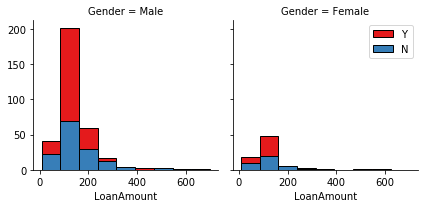

In [20]:
bins = np.linspace(train_data.LoanAmount.min(), train_data.LoanAmount.max(), 10)
g = sns.FacetGrid(train_data, col = "Gender", hue = "Loan_Status", palette = "Set1", col_wrap = 2)
g.map(plt.hist, 'LoanAmount', bins = bins, ec = "k")

g.axes[-1].legend()
plt.show()

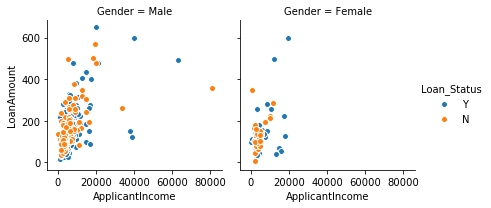

In [21]:
g = sns.FacetGrid(train_data, col="Gender",  hue = "Loan_Status")
g = (g.map(plt.scatter, "ApplicantIncome", "LoanAmount", edgecolor = "w").add_legend())
plt.show()

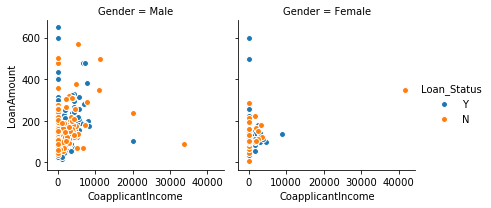

In [22]:
g = sns.FacetGrid(train_data, col="Gender",  hue = "Loan_Status")
g = (g.map(plt.scatter, "CoapplicantIncome", "LoanAmount", edgecolor = "w").add_legend())
plt.show()

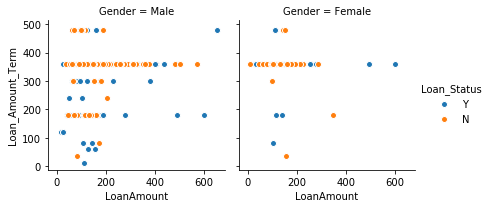

In [23]:
g = sns.FacetGrid(train_data, col="Gender",  hue = "Loan_Status")
g = (g.map(plt.scatter, "LoanAmount", "Loan_Amount_Term", edgecolor = "w").add_legend())
plt.show()

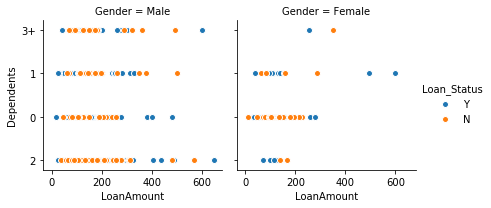

In [24]:
g = sns.FacetGrid(train_data, col="Gender",  hue = "Loan_Status")
g = (g.map(plt.scatter, "LoanAmount", "Dependents", edgecolor = "w").add_legend())
plt.show()

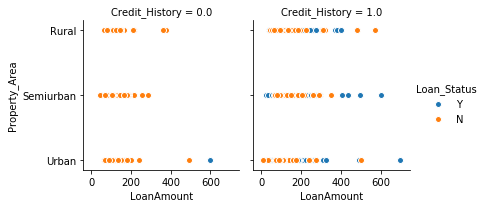

In [25]:
g = sns.FacetGrid(train_data, col="Credit_History",  hue = "Loan_Status")
g = (g.map(plt.scatter, "LoanAmount", "Property_Area", edgecolor = "w").add_legend())
plt.show()

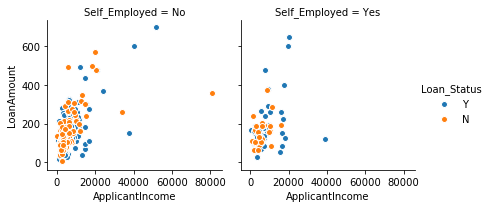

In [26]:
g = sns.FacetGrid(train_data, col="Self_Employed",  hue = "Loan_Status")
g = (g.map(plt.scatter, "ApplicantIncome", "LoanAmount", edgecolor = "w").add_legend())
plt.show()

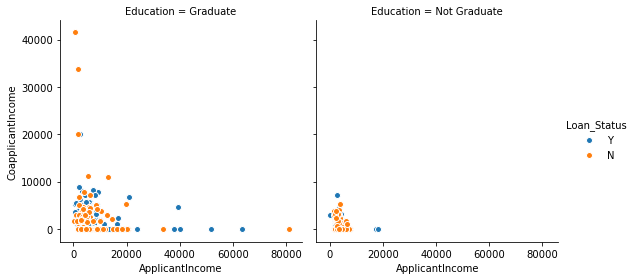

In [27]:
g = sns.FacetGrid(train_data, col="Education",  hue = "Loan_Status", height = 4, aspect = 1)
g = (g.map(plt.scatter, "ApplicantIncome", "CoapplicantIncome", edgecolor = "w").add_legend())
plt.show()

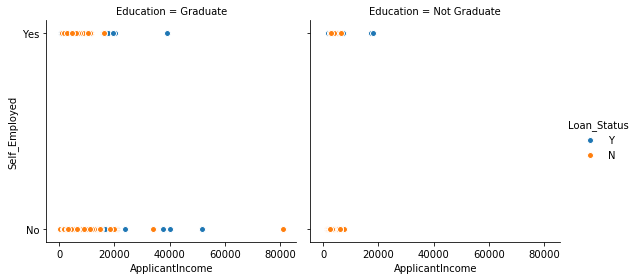

In [28]:
g = sns.FacetGrid(train_data, col="Education",  hue = "Loan_Status", height = 4, aspect = 1)
g = (g.map(plt.scatter, "ApplicantIncome", "Self_Employed", edgecolor = "w").add_legend())
plt.show()

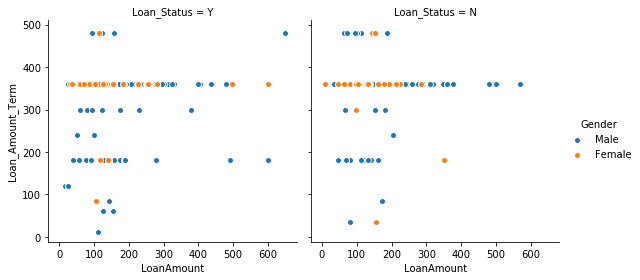

In [29]:
g = sns.FacetGrid(train_data, col="Loan_Status",  hue = "Gender", height = 4, aspect = 1)
g = (g.map(plt.scatter, "LoanAmount", "Loan_Amount_Term", edgecolor = "w").add_legend())
plt.show()

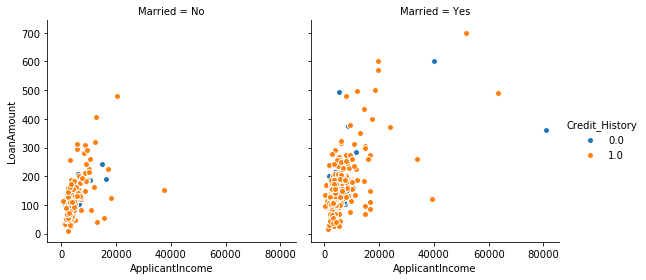

In [30]:
g = sns.FacetGrid(train_data, col="Married",  hue = "Credit_History", height = 4, aspect = 1)
g = (g.map(plt.scatter, "ApplicantIncome", "LoanAmount", edgecolor = "w").add_legend())
plt.show()

In [31]:
train_data.loc[(train_data['ApplicantIncome'] > 30000) & (train_data['Gender'].isnull()), 'Gender'] = 'Male'
train_data.loc[(train_data['Credit_History'].isnull()) & (train_data['Loan_Status'] == 'Y'), 'Credit_History'] = 1.0
train_data.loc[(train_data['Credit_History'].isnull()) & (train_data['Loan_Status'] == 'N'), 'Credit_History'] = 0
train_data['Married'] = train_data['Married'].fillna(train_data['Married'].mode()[0])
train_data.loc[(train_data['Married'] == 'Yes') & (train_data['Dependents'].isnull()), 'Dependents'] = train_data.loc[(train_data['Married'] == 'Yes') & (train_data['Dependents'].isnull()), 'Dependents'].fillna(pd.Series(np.random.choice(['1','2','3+'], size=len(train_data.index))))
train_data.loc[(train_data['Married'] == 'No') & (train_data['Dependents'].isnull()), 'Dependents'] = '0'
train_data.loc[(train_data['Education'] == 'Graduate') & (train_data['Gender'].isnull()), 'Gender'] = 'Female'
train_data.loc[(train_data['Self_Employed'].isnull()), 'Self_Employed'] = 'No'
train_data.loc[(train_data['Gender'].isnull()), 'Gender'] = 'Female'
LoanAvg = train_data.groupby('Loan_Amount_Term', as_index = False)['LoanAmount'].mean()
LoanAvg.Loan_Amount_Term = np.round(LoanAvg.Loan_Amount_Term).astype(int)
LoanAvg = LoanAvg.rename(columns={"Loan_Amount_Term": "JoinCol"})
train_data['JoinCol'] = train_data['Loan_Amount_Term']
train_data['JoinCol'] = train_data['JoinCol'].fillna(0)
train_data['JoinCol'] = np.round(train_data.JoinCol).astype(int)
train_data = train_data.join(LoanAvg.set_index('JoinCol'), on='JoinCol', how = 'left', lsuffix='_left', rsuffix='_right')
train_data['LoanAmount_left'] = train_data.LoanAmount_left.combine_first(train_data.LoanAmount_right)
train_data = train_data.rename(columns={"LoanAmount_left": "LoanAmount"})
train_data = train_data.drop(columns = ['JoinCol', 'LoanAmount_right'])
train_data.loc[(train_data['Loan_Status'] == 'Y') & (train_data['LoanAmount'] < 200) & (train_data['Loan_Amount_Term'].isnull()), 'Loan_Amount_Term'] = 360
train_data.loc[(train_data['Loan_Status'] == 'N') & (train_data['Loan_Amount_Term'].isnull()), 'Loan_Amount_Term'] = 360

In [32]:
train_data['Gender'].replace(to_replace = ['Male','Female'], value=[0, 1], inplace = True)
train_data['Married'].replace(to_replace = ['No','Yes'], value=[0, 1], inplace = True)
train_data['Education'].replace(to_replace = ['Not Graduate','Graduate'], value=[0, 1],inplace = True)
train_data['Self_Employed'].replace(to_replace = ['No','Yes'], value=[0, 1], inplace = True)
train_data['Loan_Status'].replace(to_replace = ['N','Y'], value=[0, 1], inplace = True)
train_data = train_data.drop(['Loan_ID'], axis = 1)

In [33]:
test_data.loc[(test_data['ApplicantIncome'] > 30000) & (test_data['Gender'].isnull()), 'Gender'] = 'Male'
#test_data.loc[(test_data['Credit_History'].isnull()) & (test_data['Loan_Status'] == 'Y'), 'Credit_History'] = 1.0
#test_data.loc[(test_data['Credit_History'].isnull()) & (test_data['Loan_Status'] == 'N'), 'Credit_History'] = 0
test_data['Married'] = test_data['Married'].fillna(test_data['Married'].mode()[0])
test_data.loc[(test_data['Married'] == 'Yes') & (test_data['Dependents'].isnull()), 'Dependents'] = test_data.loc[(test_data['Married'] == 'Yes') & (test_data['Dependents'].isnull()), 'Dependents'].fillna(pd.Series(np.random.choice(['1','2','3+'], size=len(test_data.index))))
test_data.loc[(test_data['Married'] == 'No') & (test_data['Dependents'].isnull()), 'Dependents'] = '0'
test_data.loc[(test_data['Education'] == 'Graduate') & (test_data['Gender'].isnull()), 'Gender'] = 'Female'
test_data.loc[(test_data['Self_Employed'].isnull()), 'Self_Employed'] = 'No'
test_data.loc[(test_data['Gender'].isnull()), 'Gender'] = 'Female'
test_data['JoinCol'] = test_data['Loan_Amount_Term']
test_data['JoinCol'] = test_data['JoinCol'].fillna(0)
test_data['JoinCol'] = np.round(test_data.JoinCol).astype(int)
test_data = test_data.join(LoanAvg.set_index('JoinCol'), on='JoinCol', how = 'left', lsuffix='_left', rsuffix='_right')
test_data['LoanAmount_left'] = test_data.LoanAmount_left.combine_first(test_data.LoanAmount_right)
test_data = test_data.rename(columns={"LoanAmount_left": "LoanAmount"})
test_data = test_data.drop(columns = ['JoinCol', 'LoanAmount_right'])
test_data.loc[(test_data['Loan_Amount_Term'].isnull()), 'Loan_Amount_Term'] = 300
test_data.loc[(test_data['Credit_History'].isnull()) & (test_data['Dependents'].isin(['0'])) & (test_data['Married'] == 'Yes') & (test_data['Education'] == 'Graduate'), 'Credit_History'] = 1
test_data.loc[(test_data['Credit_History'].isnull()) & (test_data['Dependents'].isin(['1', '3+'])) & (test_data['Married'] == 'No') & (test_data['Education'] == 'Graduate'), 'Credit_History'] = 1
test_data.loc[test_data['Credit_History'].isnull(), 'Credit_History'] = 1
#test_data.loc[(test_data['Loan_Status'] == 'Y') & (test_data['LoanAmount'] < 200), 'Loan_Amount_Term'] = 360
#test_data.loc[(test_data['Loan_Status'] == 'N'), 'Loan_Amount_Term'] = 360

In [34]:
test_data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

In [35]:
test_data['Gender'].replace(to_replace = ['Male','Female'], value=[0, 1],inplace = True)
test_data['Married'].replace(to_replace = ['No','Yes'], value=[0, 1],inplace = True)
test_data['Education'].replace(to_replace = ['Not Graduate','Graduate'], value=[0, 1],inplace = True)
test_data['Self_Employed'].replace(to_replace = ['No','Yes'], value=[0, 1],inplace = True)

In [36]:
train_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,0,0,1,0,5849,0.0,147.245436,360.0,1.0,Urban,1
1,0,1,1,1,0,4583,1508.0,128.000000,360.0,1.0,Rural,0
2,0,1,0,1,1,3000,0.0,66.000000,360.0,1.0,Urban,1
3,0,1,0,0,0,2583,2358.0,120.000000,360.0,1.0,Urban,1
4,0,0,0,1,0,6000,0.0,141.000000,360.0,1.0,Urban,1


In [37]:
test_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,0,1,0,1,0,5720,0,110.0,360.0,1.0,Urban
1,LP001022,0,1,1,1,0,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,0,1,2,1,0,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,0,1,2,1,0,2340,2546,100.0,360.0,1.0,Urban
4,LP001051,0,0,0,0,0,3276,0,78.0,360.0,1.0,Urban


In [38]:
# One hot encoding
cat_features = ['Dependents', 'Property_Area']

# Train Data
train_cat = pd.get_dummies(train_data[cat_features])
train_data = train_data.drop(cat_features, axis=1)
train_data = pd.concat([train_data, train_cat], axis = 1)

# Test data
test_cat = pd.get_dummies(test_data[cat_features])
test_data = test_data.drop(cat_features, axis=1)
test_data = pd.concat([test_data, test_cat], axis = 1)

In [39]:
# Defining X, y and splittinf the training data

X = train_data.drop('Loan_Status', axis = 1).values
y = train_data['Loan_Status'].values

# Normalize data
# Scaling the features within range (0, 1)

X = preprocessing.StandardScaler().fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

ss = StandardScaler()
scale_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
test_data[scale_features] = ss.fit_transform(test_data[scale_features])

# k Nearest Neighbor Algorithm 

In [40]:
# Finding the best k

Ks = 10
mean_acc = np.zeros((Ks - 1))
std_acc = np.zeros((Ks - 1))
ConfusionMx = [];
for n in range(1, Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print( "The best accuracy is", mean_acc.max(), "with k = ", mean_acc.argmax()+1)

The best accuracy is 0.7642276422764228 with k =  9


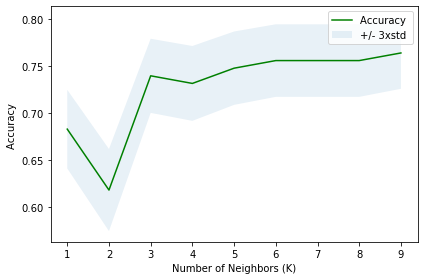

In [41]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1, Ks),mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [42]:
k = 9
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [43]:
yhatKNN = kNN_model.predict(X_test)
yhatKNN[0:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [44]:
print("Train set Accuracy using k Nearest Neighbor: ", metrics.accuracy_score(y_train, kNN_model.predict(X_train)))
print("Test set Accuracy using k Nearest Neighbor: ", metrics.accuracy_score(y_test, yhatKNN))

Train set Accuracy using k Nearest Neighbor:  0.8207739307535642
Test set Accuracy using k Nearest Neighbor:  0.7642276422764228


# Decision Tree Classifier

### Finding best depth of Decision tree

In [45]:
maxAccTree = []
for i in range(3, 40):
    Tree = DecisionTreeClassifier(criterion="entropy", max_depth = int(i))
    Tree.fit(X_train, y_train)
    PredTree = Tree.predict(X_test)
    maxAccTree.append('Accuracy with depth {i} '.format(i = str(i)) + ' is ' + str(metrics.accuracy_score(y_test, PredTree)))

In [46]:
maxAccTree

['Accuracy with depth 3  is 0.8130081300813008',
 'Accuracy with depth 4  is 0.8048780487804879',
 'Accuracy with depth 5  is 0.7967479674796748',
 'Accuracy with depth 6  is 0.8130081300813008',
 'Accuracy with depth 7  is 0.7560975609756098',
 'Accuracy with depth 8  is 0.7317073170731707',
 'Accuracy with depth 9  is 0.7642276422764228',
 'Accuracy with depth 10  is 0.7642276422764228',
 'Accuracy with depth 11  is 0.7317073170731707',
 'Accuracy with depth 12  is 0.7154471544715447',
 'Accuracy with depth 13  is 0.7317073170731707',
 'Accuracy with depth 14  is 0.6991869918699187',
 'Accuracy with depth 15  is 0.7154471544715447',
 'Accuracy with depth 16  is 0.7317073170731707',
 'Accuracy with depth 17  is 0.7317073170731707',
 'Accuracy with depth 18  is 0.7235772357723578',
 'Accuracy with depth 19  is 0.7317073170731707',
 'Accuracy with depth 20  is 0.7073170731707317',
 'Accuracy with depth 21  is 0.7073170731707317',
 'Accuracy with depth 22  is 0.7073170731707317',
 'Accur

In [ ]:
DecTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DecTree

In [ ]:
DecTree.fit(X_train, y_train)
predTree = DecTree.predict(X_test)
print (predTree [0:5])
print (y_test [0:5])

In [ ]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

In [ ]:
cm = confusion_matrix(y_test, predTree)
cm

# Support Vector Machine

### Find Best kernel for SVM

In [ ]:
for i in ('linear', 'rbf', 'sigmoid'):
    SVM = svm.SVC(kernel = str(i))
    SVM.fit(X_train, y_train)
    y_Pred = SVM.predict(X_test)
    print("SVM's Accuracy with {ker} kernel: ".format(ker = str(i)) + ' is ' + str(metrics.accuracy_score(y_test, y_Pred)))

In [ ]:
clf = svm.SVC(kernel = 'linear')
clf.fit(X_train, y_train)

In [ ]:
yhatSVM = clf.predict(X_test)
yhatSVM [0:5]

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhatSVM, labels = [1, 0])
np.set_printoptions(precision = 2)

print(classification_report(y_test, yhatSVM))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = [1, 0],normalize = False,  title = 'Confusion matrix')

# Logistic Regression 

In [ ]:
LRR = LogisticRegression(C=0.1, solver = 'saga').fit(X_train, y_train)
LRR

In [ ]:
yhat_SAG = LRR.predict(X_test)
yhat_SAG

In [ ]:
yhat_prob = LRR.predict_proba(X_test)
# yhat_prob

In [ ]:
print('Logistic Regression\'s Jaccard score: ', jaccard_similarity_score(y_test, yhat_SAG))
print('Logistic Regression\'s log loss: ', log_loss(y_test, yhat_prob))

In [ ]:
print('Classification report: \n', classification_report(y_test, yhat_SAG))

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_SAG, labels=[1, 0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 0],normalize = False,  title = 'Confusion matrix')

In [ ]:
print("F1 Score using k Nearest Neighbor: ", f1_score(y_test, yhatKNN, average = 'weighted'))
print("Jaccard Similarity score using k Nearest Neighbor: ", jaccard_similarity_score(y_test, yhatKNN))
print("F1 Score using Decision Tree Classifier: ", f1_score(y_test, predTree, average = 'weighted'))
print("Jaccard Similarity score using Decision Tree Classifier: ", jaccard_similarity_score(y_test, predTree))
print("F1 Score using SVM Classifier: ", f1_score(y_test, yhatSVM, average = 'weighted'))
print("Jaccard Similarity score using SVM Classifier: ", jaccard_similarity_score(y_test, yhatSVM))
print("F1 Score using Logistic Regression (SAGA) Classifier: ", f1_score(y_test, yhat_SAG, average = 'weighted'))
print("Jaccard Similarity score using Logistic Regression (SAGA) Classifier: ", jaccard_similarity_score(y_test, yhat_SAG))
print("Log Loss using Logistic Regression (SAGA) Classifier: ", log_loss(y_test, yhat_prob))

# Deep Neural Network

In [ ]:
ADAMAX = optimizers.Adamax(lr = 0.002, beta_1 = 0.9, beta_2 = 0.999)
# Accuracy with ADAMAX at 0.944, loss at 0.153, F1 Score at 0.5222337125129266

ADAM = optimizers.Adam(lr = 0.01)
# Accuracy with ADAM at 0.945, loss at 0.146, F1 Score at 0.517427589592538

ADADELTA = optimizers.Adadelta(lr = 1.0, rho = 0.95)
# Accuracy with ADADELTA at , loss at 0.155, F1 Score at 0.506652474720596

ANN_model = Sequential()
ANN_model.add(Dense(64, input_shape = (X_train.shape[1],), activation = 'tanh'))
ANN_model.add(Dense(64, activation = 'tanh'))
ANN_model.add(Dense(64, activation = 'tanh'))
ANN_model.add(Dense(64, activation = 'tanh'))
ANN_model.add(Dense(16, activation = 'tanh'))
# Last layer to use sigmoid activation function (coz binary classification)
ANN_model.add(Dense(1, activation = 'sigmoid'))

ANN_model.compile(optimizer = ADAMAX, loss = 'binary_crossentropy', metrics = ['accuracy'])

ANN_history = ANN_model.fit(X_train, y_train, verbose = 0, epochs = 200)
plot_loss_accuracy(ANN_history)

In [ ]:
test_data.head()

In [ ]:
test_no_id = test_data.drop('Loan_ID', axis = 1)
test_predictions = ANN_model.predict(test_no_id)
Loan_ID = test_data['Loan_ID']
submission_df = pd.DataFrame({
                  "Loan_ID": Loan_ID, 
                  "Loan_Status": test_predictions.ravel()})

In [ ]:
submission_df.head()

In [ ]:
submission_df.Loan_Status = submission_df.Loan_Status.round()
submission_df['Loan_Status'].replace(to_replace = [0, 1], value=['N', 'Y'], inplace = True)

In [ ]:
submission_df.head()

In [ ]:
submission_df.to_csv('submission_1.csv', index = False)

In [ ]:
temp = train_data[['Loan_Amount_Term', 'LoanAmount']].copy()

In [ ]:
LoanAvg

In [ ]:
pd.merge_asof(train_data, LoanAvg, on = 'Score')

In [ ]:
test_data[test_data['Credit_History'].isnull()]

In [ ]:
train_data[train_data['LoanAmount'].isnull()]

In [ ]:
train_data.Gender

In [ ]:
train_data.describe()

In [ ]:
test_data.isnull().sum()

In [ ]:
train_data.nunique()

In [ ]:
test_data.shape

In [ ]:
# See y distribution

sns.countplot(train_data['Loan_Status'])

In [ ]:
train_data.shape

In [ ]:
train_data.dtypes

In [ ]:
LoanAvg

In [ ]:
train_data.loc[(train_data.JoinCol.isin(LoanAvg.Loan_Amount_Term)) & (train_data['LoanAmount'].isnull()), ['LoanAmount']]